<h1><center><u>IU-WeightedSAC -- 2D Navigation Robot(particle) Environment</u></center></h1> 

In [1]:
import os
import joblib
import importlib
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib notebook
# %matplotlib nbagg
%matplotlib notebook

from robolearn.envs.simple_envs.goal_composition import GoalCompositionEnv
from robolearn.envs.normalized_box_env import NormalizedBoxEnv

from robolearn.torch.models import NNQFunction, NNVFunction
from robolearn.torch.models import NNMultiQFunction, NNMultiVFunction

from robolearn.torch.policies import TanhGaussianWeightedMultiPolicy

from robolearn.torch.rl_algos.sac.iu_weightedmultisac import IUWeightedMultiSAC

from robolearn.utils.data_management import MultiGoalReplayBuffer

from robolearn.utils.launchers.launcher_util import setup_logger
import robolearn.torch.pytorch_util as ptu
from robolearn.core import logger
from robolearn.utils.plots import get_csv_data
from robolearn.utils.plots import subplots

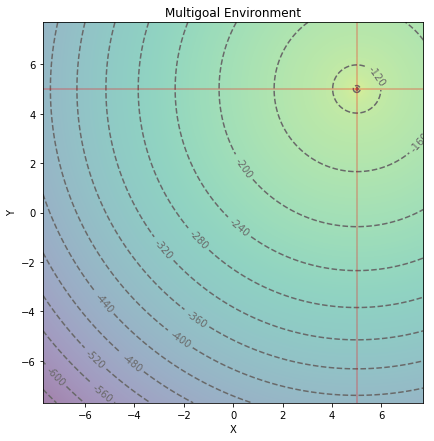

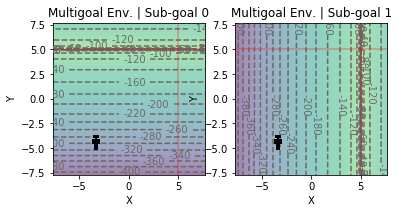

In [2]:
def create_environment():
    # Environment
    env = GoalCompositionEnv(
        goal_reward=50,
        actuation_cost_coeff=0.5,
        distance_cost_coeff=1.5,
        log_distance_cost_coeff=10.0,
        alpha=1e-3,
        # Initial Condition
        init_position=(-4., -4.),
        init_sigma=1.50,
        # Goal
        goal_position=(5., 5.),
        goal_threshold=0.05,
        # Others
        dynamics_sigma=0.1,
        # horizon=PATH_LENGTH,
        horizon=None,
    )

    # Normalize environment
    env = NormalizedBoxEnv(
        env,
        normalize_obs=False,
        online_normalization=False,
        obs_mean=None,
        obs_var=None,
        obs_alpha=0.001,
    )

    # Visualize costs
    env.reset()
    env.render()
#     env.close()
    return env
env = create_environment()

# IU-SAC

In [3]:
# Common parameters
n_unintentions = env.n_subgoals
obs_dim = np.prod(env.observation_space.shape)
action_dim = np.prod(env.action_space.shape)

In [4]:
def create_value_fcns(net_size=32):
    # --------------------- #
    # Value Function Models #
    # --------------------- #



    # Unintentional Value functions --> Environment sub-goals (sub-tasks)
    u_qf = NNMultiQFunction(obs_dim=obs_dim,
                           action_dim=action_dim,
                           n_qs=n_unintentions,
                           shared_hidden_sizes=(),
                           unshared_hidden_sizes=(net_size, net_size),
                           )

    u_qf2 = NNMultiQFunction(obs_dim=obs_dim,
                            action_dim=action_dim,
                            n_qs=n_unintentions,
                            shared_hidden_sizes=(),
                            unshared_hidden_sizes=(net_size, net_size),
                            )
    u_vf = NNMultiVFunction(obs_dim=obs_dim,
                           n_vs=n_unintentions,
                           shared_hidden_sizes=(),
                           unshared_hidden_sizes=(net_size, net_size)
                           )

    # Intentional Value function --> Environment goal (full task)
    i_qf = NNQFunction(obs_dim=obs_dim,
                      action_dim=action_dim,
                      hidden_sizes=(net_size, net_size))

    i_qf2 = NNQFunction(obs_dim=obs_dim,
                       action_dim=action_dim,
                       hidden_sizes=(net_size, net_size))

    i_vf = NNVFunction(obs_dim=obs_dim,
                      hidden_sizes=(net_size, net_size))
    
    return u_qf, u_qf2, u_vf, i_qf, i_qf2, i_vf

# Hyperparameters
net_size = 32
u_qf, u_qf2, u_vf, i_qf, i_qf2, i_vf = create_value_fcns(net_size)

In [5]:
def create_policy(
    net_size=32,
    n_shared_layers=0,
    n_unshared_layers=2,
    n_mix_layers=2,
    shared_norm=False,
    unshared_norm=False,
    mix_norm=False,
):
    # ------ #
    # Policy #
    # ------ #
    policy = TanhGaussianWeightedMultiPolicy(
        obs_dim=obs_dim,
        action_dim=action_dim,
        n_policies=n_unintentions,
        shared_hidden_sizes=[net_size for _ in range(n_shared_layers)],
        unshared_hidden_sizes=[net_size for _ in range(n_unshared_layers)],
        unshared_mix_hidden_sizes=[net_size for _ in range(n_mix_layers)],
        stds=None,
        shared_layer_norm=shared_norm,
        unshared_layer_norm=unshared_norm,
        mixture_layer_norm=mix_norm,
        mixing_temperature=1.,
        reparameterize=True,
    )
    return policy

# Hyperparameters
net_size = 32
n_shared_layers = 0
n_unshared_layers = 2
n_mix_layers = 2
shared_norm = False
unshared_norm = False
mix_norm = False
policy = create_policy(net_size=net_size, n_shared_layers=n_shared_layers, n_unshared_layers=n_unshared_layers,
                      n_mix_layers=n_mix_layers, shared_norm=shared_norm, unshared_norm=unshared_norm, mix_norm=mix_norm)

In [6]:
# --------- #
# Algorithm #
# --------- #

# Hypeparameters
render = False
reward_scale=1.0e-1
n_epochs = 500
replay_buffer_size = 1e3
batch_size=128

paths_per_epoch = 5
paths_per_eval = 3
path_length = 50

algo_hyperparams = dict(
    # Common RL algorithm params
    num_steps_per_epoch=paths_per_epoch * path_length,
    num_epochs=n_epochs,
    num_updates_per_train_call=1,
    num_steps_per_eval=paths_per_eval * path_length,
    # EnvSampler params
    max_path_length=path_length,
    render=render,
    # SAC params
    min_steps_start_train=batch_size,
    min_start_eval=paths_per_epoch * path_length,
    reparameterize=True,
    action_prior='uniform',
    i_entropy_scale=1.0e-0,
    u_entropy_scale=[1.0e-0, 1.0e-0],
    
    discount=0.99,
    reward_scale=reward_scale,
    u_reward_scales=[reward_scale for _ in range(n_unintentions)],
)

# Replay Buffer
replay_buffer = MultiGoalReplayBuffer(
    max_replay_buffer_size=replay_buffer_size,
    obs_dim=obs_dim,
    action_dim=action_dim,
    reward_vector_size=n_unintentions,
)
# Algorithm
algorithm = IUWeightedMultiSAC(
    env=env,
    policy=policy,
    u_qf=u_qf,
    u_vf=u_vf,
    replay_buffer=replay_buffer,
    batch_size=batch_size,
    i_qf=i_qf,
    i_vf=i_vf,
    u_qf2=u_qf2,
    i_qf2=i_qf2,
    eval_env=env,
    save_environment=False,
    **algo_hyperparams,
)

# Logger
log_dir = setup_logger(
    'notebook_2d_nav_'+str(type(algorithm).__name__),
    variant=algo_hyperparams,
    snapshot_mode='gap_and_last',
    snapshot_gap=25,
    log_dir=None,
    log_stdout=False,
)

2018-09-21 18:50:41.275406 CEST | Variant:
2018-09-21 18:50:41.275939 CEST | {
  "num_steps_per_epoch": 250,
  "num_epochs": 500,
  "num_updates_per_train_call": 1,
  "num_steps_per_eval": 150,
  "max_path_length": 50,
  "render": false,
  "min_steps_start_train": 128,
  "min_start_eval": 250,
  "reparameterize": true,
  "action_prior": "uniform",
  "i_entropy_scale": 1.0,
  "u_entropy_scale": [
    1.0,
    1.0
  ],
  "discount": 0.99,
  "reward_scale": 0.1,
  "u_reward_scales": [
    0.1,
    0.1
  ]
}


In [7]:
seed = 10
start_epoch = 0

use_gpu = False

env.seed(seed)
ptu.seed(seed)

ptu.set_gpu_mode(use_gpu)
if ptu.gpu_enabled():
    algorithm.cuda()

algorithm.train(start_epoch=start_epoch)

000 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
001 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
002 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
003 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
004 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
005 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
006 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
007 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
008 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
009 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
010 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
011 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
012 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
013 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
014 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
015 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
016 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
017 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
018 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
019 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
020 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
021 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
022 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
023 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
024 TODO: WE NEE

200 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
201 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
202 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
203 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
204 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
205 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
206 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
207 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
208 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
209 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
210 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
211 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
212 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
213 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
214 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
215 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
216 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
217 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
218 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
219 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
220 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
221 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
222 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
223 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
224 TODO: WE NEE

400 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
401 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
402 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
403 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
404 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
405 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
406 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
407 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
408 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
409 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
410 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
411 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
412 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
413 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
414 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
415 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
416 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
417 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
418 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
419 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
420 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
421 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
422 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
423 TODO: WE NEED LOG_DIAGNOSTICS IN ENV
424 TODO: WE NEE

Max path length: 50


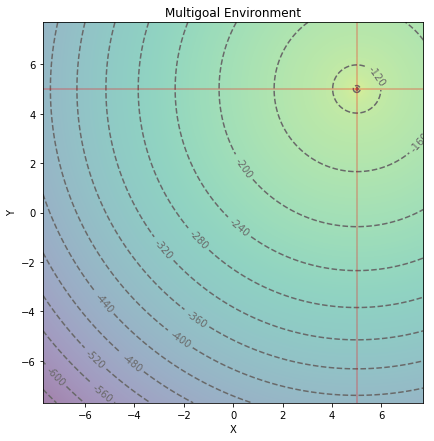

Environment done!


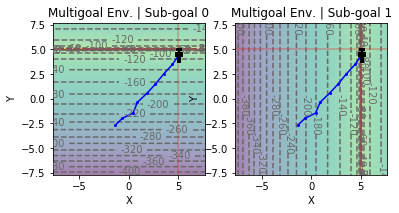

In [8]:
# Test
deterministic = True
subpolicy = 1 # None or int
print('Max path length:', path_length)

env.close()
obs = env.reset()
for t in range(path_length):
    env.render()
    action, pol_info = policy.get_action(obs, pol_idx=subpolicy)
    obs, reward, done, env_info = env.step(action)
#     print('obs:', obs, '| goal:', env.wrapped_env.goal_position, ' | reward:', reward)
#     print('---')
    if done:
        print('Environment done!')
        break

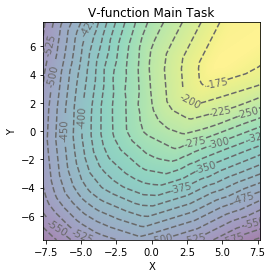

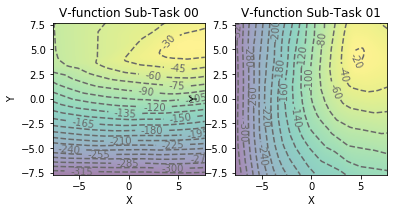

In [9]:
def plot_v_fcn():
    xlim = (-7, 7)
    ylim = (-7, 7)
    delta = 0.01
    x_min, x_max = tuple(1.1 * np.array(xlim))
    y_min, y_max = tuple(1.1 * np.array(ylim))
    all_x = np.arange(x_min, x_max, delta)
    all_y = np.arange(y_min, y_max, delta)
    xy_mesh = np.meshgrid(all_x, all_y)
    all_obs = np.array(xy_mesh).T.reshape(-1, 2)
    
    def plot_v_contours(ax, values):
        values = values.reshape(len(all_x), len(all_y))

        contours = ax.contour(xy_mesh[0], xy_mesh[1], values, 20,
                          colors='dimgray')
        ax.clabel(contours, inline=1, fontsize=10, fmt='%.0f')
        ax.imshow(values, extent=(x_min, x_max, y_min, y_max), origin='lower',
                  alpha=0.5)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('equal')
        ax.set_aspect('equal', 'box')
    
    # Compute and plot Main Task Value-fcn
    values, _ = i_vf.get_values(all_obs)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_title('V-function Main Task')
    plot_v_contours(ax, values)
    
    # Compute and plot Sub-tasks Value-fcn
    n_cols = 2
    n_rows = int(np.ceil(n_unintentions/n_cols))
    subgoals_fig, subgoals_axs = plt.subplots(n_rows, n_cols)
    
    subgoals_axs = np.atleast_2d(subgoals_axs)
    
    
    for aa in range(n_unintentions):
        row = aa // n_cols
        col = aa % n_cols
        subgo_ax = subgoals_axs[row, col]
        values, _ = u_vf.get_values(all_obs, val_idxs=[aa])
        values = values[0]
        
        subgo_ax.set_title('V-function Sub-Task %02d' % aa)
        plot_v_contours(subgo_ax, values)
        
    
plot_v_fcn()

---
---
---
---
---


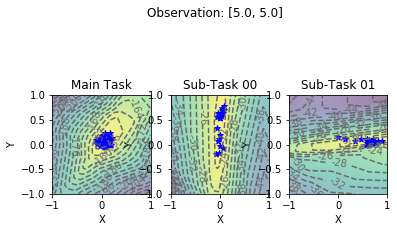

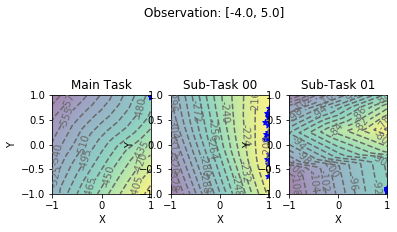

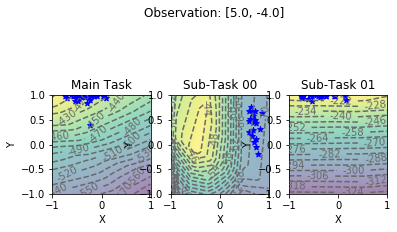

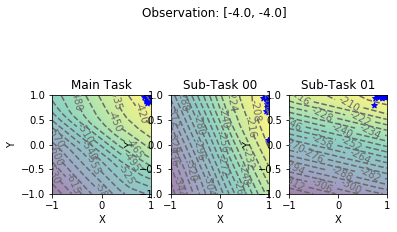

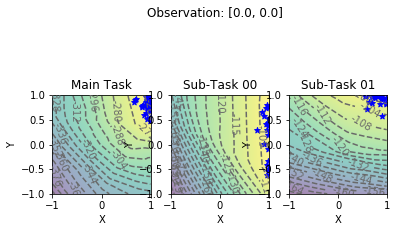

In [10]:
def plot_q_fcn(obs):
    delta = 0.01
    x_min, y_min = env.action_space.low
    x_max, y_max = env.action_space.high
    xlim = (x_min, x_max)
    ylim = (y_min, y_max)
    all_x = np.arange(x_min, x_max, delta)
    all_y = np.arange(y_min, y_max, delta)
    xy_mesh = np.meshgrid(all_x, all_y)

    all_acts = np.zeros((len(all_x)*len(all_y), 2))
    all_acts[:, 0] = xy_mesh[0].ravel()
    all_acts[:, 1] = xy_mesh[1].ravel()
     
    all_obs = np.broadcast_to(obs, (all_acts.shape[0], 2))
    
    def plot_q_contours(ax, q_values):
        q_values = q_values.reshape(len(all_x), len(all_y))

        contours = ax.contour(xy_mesh[0], xy_mesh[1], q_values, 20,
                          colors='dimgray')
        ax.clabel(contours, inline=1, fontsize=10, fmt='%.0f')
        ax.imshow(q_values, extent=(x_min, x_max, y_min, y_max), origin='lower',
                  alpha=0.5)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('equal')
        ax.set_aspect('equal', 'box')
    
    def plot_action_samples(ax, actions):
        x, y = actions[:, 0], actions[:, 1]
        ax.scatter(x, y, c='b', marker='*')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
   
    fig, all_axs = plt.subplots(1, n_unintentions + 1)
    fig.suptitle('Observation: ' +  str(obs))

    # Compute and plot Main Task State Value-fcn
    all_axs[0].set_title('Main Task')
    q_values, _ = i_qf.get_values(all_obs, all_acts)
    
    plot_q_contours(all_axs[0], q_values)
    
    # Compute and plot Main Task State-Action Value-fcn
    action_samples, _ = policy.get_actions(all_obs[:50, :], pol_idx=None)
    plot_action_samples(all_axs[0], action_samples)
    
    for aa in range(n_unintentions):
        subgo_ax = all_axs[aa + 1]
        subgo_ax.set_title('Sub-Task %02d' % aa)
        
        q_values, _ = u_qf.get_values(all_obs, all_acts, val_idxs=[aa])
        q_values = q_values[0]        
        plot_q_contours(subgo_ax, q_values)
        
        action_samples, _ = policy.get_actions(all_obs[:20, :], pol_idx=aa)
        plot_action_samples(subgo_ax, action_samples)       

all_obs = [
    [5., 5.],
    [-4., 5.],
    [5., -4.],
    [-4., -4.],
    [0., 0.],
]

for obs in all_obs:
    plot_q_fcn(obs)
    print('---')

['[U-00] Policy Entropy', '[U-00] Qf Loss', '[U-00] Vf Loss', '[U-00] Pol KL Loss', '[U-00] Rewards', '[U-00] Mixing Weights', '[U-00] Policy Std [00]', '[U-00] Policy Mean [00]', '[U-00] Policy Std [01]', '[U-00] Policy Mean [01]', '[U-01] Policy Entropy', '[U-01] Qf Loss', '[U-01] Vf Loss', '[U-01] Pol KL Loss', '[U-01] Rewards', '[U-01] Mixing Weights', '[U-01] Policy Std [00]', '[U-01] Policy Mean [00]', '[U-01] Policy Std [01]', '[U-01] Policy Mean [01]', '[I] Policy Entropy', '[I] Qf Loss', '[I] Vf Loss', '[I] Pol KL Loss', '[I] Rewards', '[I] Policy Std [%02d]', '[I] Policy Mean [%02d]', '[U-00] Test Rewards Mean', '[U-00] Test Rewards Std', '[U-00] Test Rewards Max', '[U-00] Test Rewards Min', '[U-00] Test Returns Mean', '[U-00] Test Returns Std', '[U-00] Test Returns Max', '[U-00] Test Returns Min', '[U-00] Test Actions Mean', '[U-00] Test Actions Std', '[U-00] Test Actions Max', '[U-00] Test Actions Min', 'Num Paths', '[U-00] Test AverageReward', '[U-00] Test AverageReturn', 

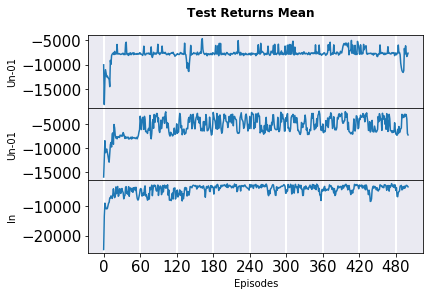

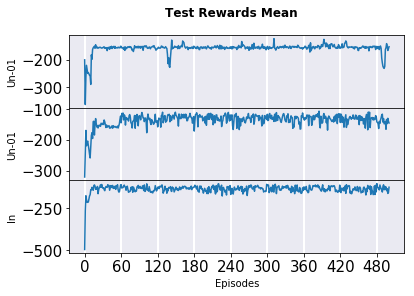

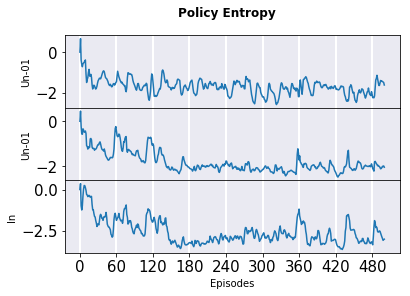

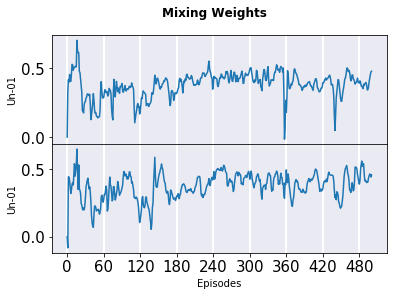

In [11]:
snapshot_dir = logger.get_snapshot_dir()

data_file = os.path.join(snapshot_dir, 'progress.csv')

def plot_data(csv_file, label='Policy Entropy', plot_intentional=True):
    labels_to_plot = list()
    
    for uu in range(n_unintentions):
        labels_to_plot.append(('[U-%02d] ' % uu) + label)
        
    if plot_intentional:
        n_subplots = n_unintentions + 1
        labels_to_plot.append('[I] ' + label)
    else:
        n_subplots = n_unintentions

    data = get_csv_data(csv_file, labels_to_plot)

    fig, axs = subplots(n_subplots)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    fig.subplots_adjust(hspace=0)
    fig.suptitle(label,
                 fontweight='bold')

    for aa, ax in enumerate(axs):
        ax.plot(data[aa])
        if aa < n_unintentions:
            ylabel = 'Un-%02d' % uu
        else:
            ylabel = 'In'
        ax.set_ylabel(ylabel)
        plt.setp(ax.get_xticklabels(), visible=False)

    axs[-1].set_xlabel('Episodes')
    plt.setp(axs[-1].get_xticklabels(), visible=True)

    
plot_data(data_file, label='Test Returns Mean')
print('--')
plot_data(data_file, label='Test Rewards Mean')
print('--')
plot_data(data_file, label='Policy Entropy')
print('--')
plot_data(data_file, label='Mixing Weights', plot_intentional=False)
